Весь файл запускать сразу не следует!

# Подключаем библиотеки и загружаем базу данных



In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt

from tensorflow import keras

import statsmodels.api as sm

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher

In [ ]:
url='https://drive.google.com/file/d/1rBP_uxoyafzrhQnXQPAENWiBVc6Z8W7F/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


# Подготавливаем данные


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 68.2+ MB


In [ ]:
#проверим количество нулевых элементов в нашем датасете для каждого из параметров
df.isnull().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

In [ ]:
#выбросим все строки содержащие нулевые элементы
df.dropna(inplace=True)
#как видим все они удалились
df.isnull().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
mmr             0
sellingprice    0
saledate        0
dtype: int64

Теперь рассмотрим три параметра seller, VIN, saledate vs. sallingprice

In [ ]:
# посмотрим кол-во продавцов
df['seller'].nunique()

11923

In [ ]:
# тут захэшируем наших продавцов
sellers = []
seller = list(df['seller'])
for el in seller:
  sellers.append((abs(hash(el)) % (10**8)) / 10000000)

In [ ]:
pd.DataFrame(sellers).nunique() # уникальных значений осталось столько же

0    11923
dtype: int64

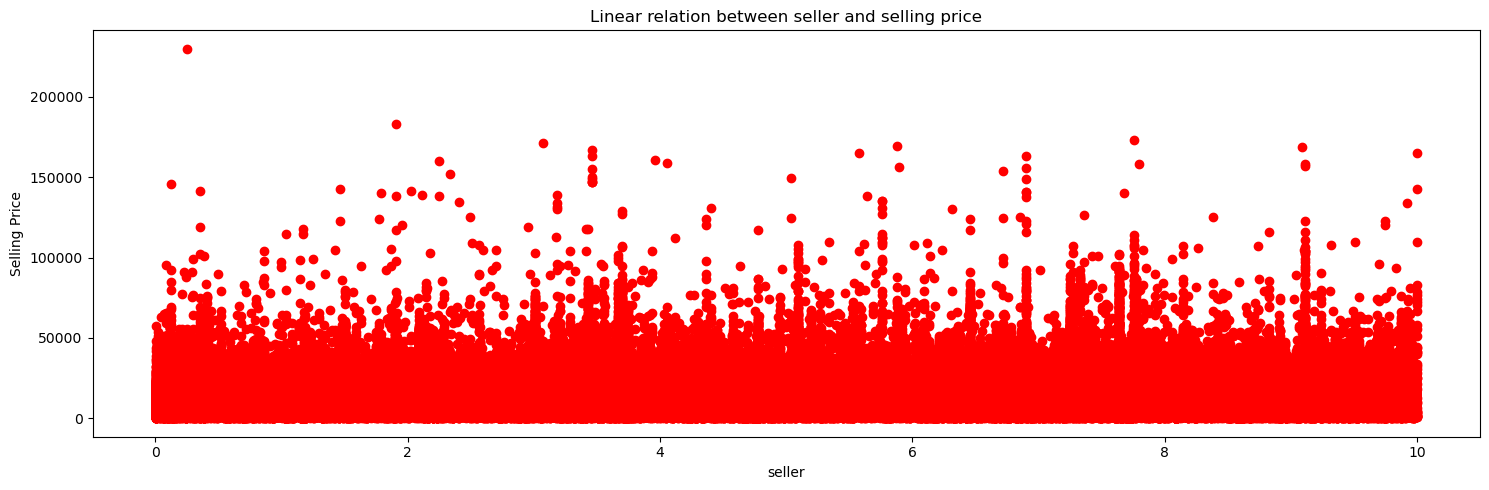

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(sellers, df['sellingprice'], color='red')
plt.xlabel("seller")
plt.ylabel('Selling Price')
plt.title("Linear relation between seller and selling price")
plt.tight_layout()
plt.show()

Во-первых продавцов много, во-вторых от продовца стоимость не зависит, по-этому исключим это.

In [ ]:
# так теперь обработаем дату продажи, если она в неправильном формате, то сопаставим ноль, иначе количество дней от начала минимального года
def class_month(a):
  if a == 'Jan':
    return 0
  if a == 'Feb':
    return 31
  if a == 'Mar':
    return 59
  if a == 'Apr':
    return 90
  if a == 'May':
    return 120
  if a == 'Jun':
    return 151
  if a == 'Jul':
    return 181
  if a == 'Aug':
    return 212
  if a == 'Sep':
    return 243
  if a == 'Oct':
    return 273
  if a == 'Nov':
    return 304
  if a == 'Dec':
    return 334

sale_date = df['saledate']

n_sale_date = []
for el in sale_date:
  n_sale_date.append(el.split())

In [ ]:
# пример одной правильно заполненной ячейки
n_sale_date[1]

['Tue', 'Dec', '16', '2014', '12:30:00', 'GMT-0800', '(PST)']

In [ ]:
years = []
for el in n_sale_date:
  years.append(int(el[3]))

min_year = min(years)

f_sale_date = []
for el in n_sale_date:
  if len(el) == 7:
    f_sale_date.append(int(el[2]) + class_month(el[1]) + ((int(el[3]) - min_year) * 365))
  else:
    f_sale_date.append(0)

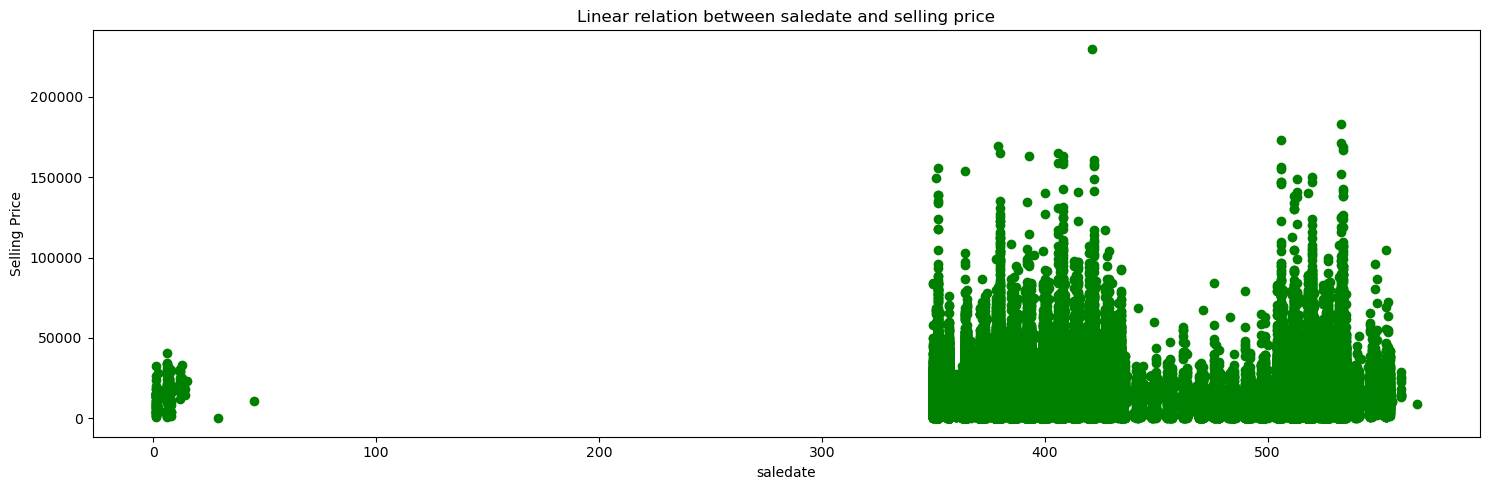

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(f_sale_date, df['sellingprice'], color='green')
plt.xlabel("saledate")
plt.ylabel('Selling Price')
plt.title("Linear relation between saledate and selling price")
plt.tight_layout()
plt.show()

Вообщем получаем, что цена никак особо и не зависит от продажи, у нас так же есть нулевые элементы, а это значит, что в некоторых записях дата в некоректном виде. В середине есть "просадка", но там просто меньше машин было продано, поэтому и разнообразность цен меньше.

In [ ]:
#так как база данных слишком большая возьмем только ее часть
df = df.sample(frac=0.6, random_state=1, ignore_index=True)
#так же выкинем столбцы с вин, так как он у всех машин разный,
#продавцом и датой продажи, так как они не влияют
df.drop(['seller', 'vin', 'saledate'], axis=1, inplace=True)
print(df.shape)
df.head()

(283395, 13)


,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,mmr,sellingprice
0,2014,Ford,Mustang,V6,Coupe,automatic,mo,39.0,25416.0,white,black,18300.0,17800.0
1,2012,Nissan,Altima,2.5 S,Sedan,automatic,mo,35.0,44298.0,burgundy,tan,11400.0,12800.0
2,2005,Chrysler,300,C,Sedan,automatic,il,19.0,80882.0,green,gray,7625.0,5900.0
3,2003,Nissan,Altima,2.5 SL,Sedan,automatic,pa,27.0,126454.0,blue,gray,2775.0,2600.0
4,2011,Nissan,Maxima,3.5 SV,Sedan,automatic,fl,47.0,45138.0,black,tan,16200.0,16200.0


In [ ]:
#определим функцию которая будет нам выводить количество уникальных данных для каждой категории нашего датасета
categ = ['make', 'model', 'trim', 'body', 'state', 'color', 'interior', 'transmission']
def printUniqueAmount(df):
  for col in categ:
    print(f"{col}: {df[col].nunique()}")

In [ ]:
printUniqueAmount(df)

make: 53
model: 749
trim: 1434
body: 85
state: 34
color: 20
interior: 17
transmission: 2


In [ ]:
#если какая-то категория встречается меньше 10 раз, то мы заменяем на 'Other'
for col in categ:
    amount = df[col].value_counts()
    rare_categories = amount[amount <= 10].index.tolist()
    df[col] = df[col].apply(lambda x: 'Other' if x in rare_categories else x)

In [ ]:
#теперь наше кол-во уникальных категорий:
printUniqueAmount(df)

make: 49
model: 585
trim: 797
body: 63
state: 34
color: 20
interior: 17
transmission: 2


In [ ]:
#год выпуска машины меняем на возраст машины
df['cars_age'] = df['year'].apply(lambda x : 2015 - x)
#transmissiom переводим automatic - 0, manual - 1
df = pd.get_dummies(data=df, columns=['transmission'], drop_first=True, dtype=int)
#так же переводим наши категориальные данные с помощью BinaryEncoder
encoder = ce.binary.BinaryEncoder(cols=['make','body','interior','color','state'],drop_invariant=True).fit(df)
df = encoder.transform(df)
#так же преобразуем с помощью hasher текстовые данные
hasher = FeatureHasher(n_features=40, input_type='string')
hashed_features = hasher.transform(df[['model', 'trim']].astype(str).to_numpy())
hashed_features_df = pd.DataFrame(hashed_features.toarray())
hashed_features_df.columns = ['feature_' + str(i) for i in range(hashed_features_df.shape[1])]
#убираем year, model, trim, потому что мы их заменили другими
df.drop(['year', 'model', 'trim'], axis=1, inplace=True)
#склеим все получившиеся данные
df = pd.concat([df, hashed_features_df], axis=1)

df.head()

,make_0,make_1,make_2,make_3,make_4,make_5,body_0,body_1,body_2,body_3,...,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39
0,0,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,0,1,0,0,0,0,0,...,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283395 entries, 0 to 283394
Data columns (total 74 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   make_0               283395 non-null  int64  
 1   make_1               283395 non-null  int64  
 2   make_2               283395 non-null  int64  
 3   make_3               283395 non-null  int64  
 4   make_4               283395 non-null  int64  
 5   make_5               283395 non-null  int64  
 6   body_0               283395 non-null  int64  
 7   body_1               283395 non-null  int64  
 8   body_2               283395 non-null  int64  
 9   body_3               283395 non-null  int64  
 10  body_4               283395 non-null  int64  
 11  body_5               283395 non-null  int64  
 12  state_0              283395 non-null  int64  
 13  state_1              283395 non-null  int64  
 14  state_2              283395 non-null  int64  
 15  state_3          

In [ ]:
#предсказывать будем стоимость машины
#разделяем на обучающий и тестовый наборы
X = df.drop(['sellingprice'], axis=1)
y = df['sellingprice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#нормализуем наши данные для лучших результатов обучения
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#посмотрим на наши поолучившиеся значения после нормализации
print("Набор для обучения X:\n", X_train)
print("Тестовый набор X:\n", X_test)

Набор для обучения X:
 [[-0.15789894  1.78220326 -0.70851778 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894 -0.56110323  1.41139719 ...  0.00707289  0.11345535
   6.18216708]
 [-0.15789894 -0.56110323  1.41139719 ...  0.00707289  0.11345535
  -0.06124557]
 ...
 [-0.15789894 -0.56110323 -0.70851778 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894 -0.56110323 -0.70851778 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894 -0.56110323  1.41139719 ...  0.00707289  0.11345535
  -0.06124557]]
Тестовый набор X:
 [[-0.15789894  1.78220326  1.41139719 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894  1.78220326  1.41139719 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894  1.78220326  1.41139719 ...  0.00707289 -6.86677369
  -0.06124557]
 ...
 [-0.15789894  1.78220326 -0.70851778 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894 -0.56110323 -0.70851778 ...  0.00707289  0.11345535
  -0.06124557]
 [-0.15789894 -0.56110323 -0.70851778 ...  0.00707289  0

# Функция для оценки результатов

In [ ]:
#функция для оценки результатов
def print_res(pred, y_test, pred_train, y_train):
  delta = pred_train - y_train
  absDelta = abs(delta)
  print("Средняя ошибка для обучающего набора: ")
  print(sum(absDelta) / len(absDelta))

  delta = pred - y_test
  absDelta = abs(delta)
  print("Средняя ошибка для тестового: ")
  print(sum(absDelta) / len(absDelta))

  plt.scatter(y_test, pred, label='test')
  plt.scatter(y_train, pred_train, label='train')
  plt.xlabel('Правильные значение')
  plt.ylabel('Предсказания')
  plt.legend()
  plt.axis('equal')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.show()

  print("Для обучающего набора:")
  print('Реальное значение:\n', y_train[:5], "\nПредсказанное значение:\n", pred_train[:5])
  print("Для тестовых:")
  print('Реальное значение\n', y_test[:5], "\nПредсказанное значение\n", pred[:5])

# Создаем и обучаем нейросеть

In [ ]:
#создаем модель нейронки
model = keras.Sequential([
    keras.Input(shape=(73,)),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1),
])


model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4), loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)

Epoch 1/100
5668/5668 [==============================] - 28s 5ms/step - loss: 34608712.0000 - mae: 3191.8396 - val_loss: 4342794.0000 - val_mae: 1445.3265
Epoch 2/100
5668/5668 [==============================] - 16s 3ms/step - loss: 3813466.2500 - mae: 1334.4225 - val_loss: 3650823.7500 - val_mae: 1297.3737
Epoch 3/100
5668/5668 [==============================] - 16s 3ms/step - loss: 3405007.2500 - mae: 1241.9723 - val_loss: 3370299.0000 - val_mae: 1225.2903
Epoch 4/100
5668/5668 [==============================] - 17s 3ms/step - loss: 3184027.2500 - mae: 1188.1024 - val_loss: 3204529.5000 - val_mae: 1187.3063
Epoch 5/100
5668/5668 [==============================] - 15s 3ms/step - loss: 3040017.7500 - mae: 1151.6312 - val_loss: 3086039.2500 - val_mae: 1156.0151
Epoch 6/100
5668/5668 [==============================] - 17s 3ms/step - loss: 2935473.7500 - mae: 1124.5543 - val_loss: 3055510.2500 - val_mae: 1144.9955
Epoch 7/100
5668/5668 [==============================] - 17s 3ms/step - los

In [ ]:
#теперь посмотрим нашу модель на тестовых данных и ошибки которые она дает
test_loss = model.evaluate(X_test, y_test)
test_loss

1772/1772 [==============================] - 3s 1ms/step - loss: 2339773.2500 - mae: 984.4457


[2339773.25, 984.4456787109375]

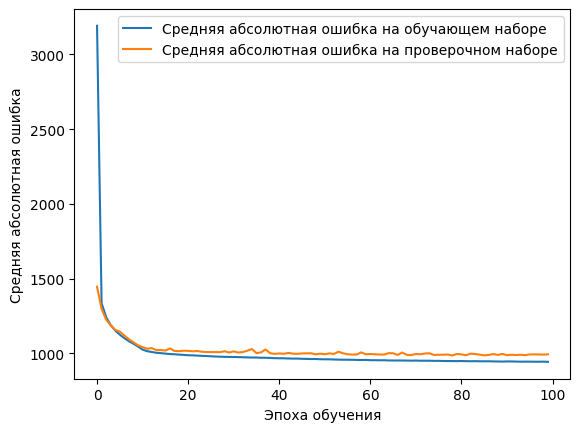

In [ ]:
#построим графики ошибки от эпох обучения
plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

7085/7085 [==============================] - 10s 1ms/step
Средняя ошибка для обучающего набора: 
949.4937874271596
Средняя ошибка для тестового: 
984.4448652974648


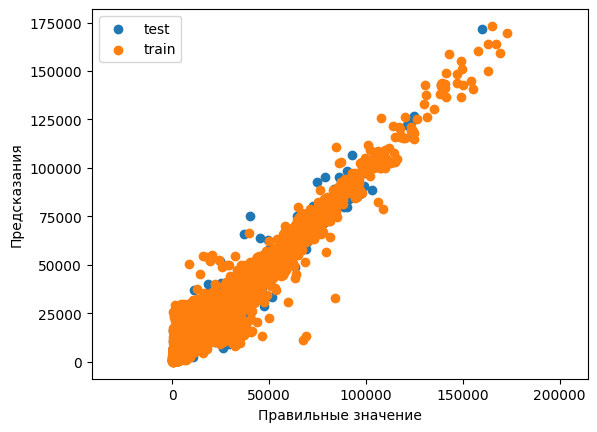

Для обучающего набора:
Реальное значение:
 258530    19000.0
14229     13100.0
158367    10500.0
11039      5750.0
142257    18800.0
Name: sellingprice, dtype: float64 
Предсказанное значение:
 [20277.18  13057.574  9884.089 12471.557 19155.719]
Для тестовых:
Реальное значение
 245631    10200.0
84047     13900.0
148609    20300.0
18574     15400.0
137346    12900.0
Name: sellingprice, dtype: float64 
Предсказанное значение
 [11833.121  9583.675 20136.857 15420.583 11262.234]


In [ ]:
#посмотрим какая средняя разница между предугаданными значениями и реальными
pred = model.predict(X_test)
pred = pred.flatten()

pred_train = model.predict(X_train)
pred_train = pred_train.flatten()

print_res(pred, y_test, pred_train, y_train)

После ста эпох ошибка на проверочном наборе начинает возрастать, поэтому выберем 100 эпох

Получаем хорошие результаты.

Теперь обучим нормализованным данным.

# Нормализация данных

In [ ]:
#нормализуем данные y_train
yScaler = StandardScaler()

yScaler.fit(np.array(y_train).reshape(-1, 1))

#нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(np.array(y_train).reshape(-1, 1))

print(yTrainScaled.shape)
print(y_train[1])
print(yTrainScaled[1])

(226716, 1)
12800.0
[-0.05949141]


In [ ]:
#нормализуем данные y_test
yScalerTest = StandardScaler()

yScalerTest.fit(np.array(y_test).reshape(-1, 1))

#нормализуем по нормальному распределению
yTestScaled = yScalerTest.transform(np.array(y_test).reshape(-1, 1))

print(yTestScaled.shape)
print(y_train[1])
print(yTestScaled[1])

(56679, 1)
12800.0
[0.01457666]


In [ ]:
#посмотрим, что у нас получилось
print("Train:")
print(min(y_train), max(y_train))
print(min(yTrainScaled), max(yTrainScaled))
print("Test:")
print(min(y_test), max(y_test))
print(min(yTestScaled), max(yTestScaled))

Train:
100.0 173000.0
[-1.41250964] [16.58263274]
Test:
100.0 160000.0
[-1.41848157] [15.18630184]


# Нейросеть на нормализованных данных

In [ ]:
#создаем модель нейронки
modelS = keras.Sequential([
    keras.Input(shape=(73,)),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(80, activation='relu'),
    keras.layers.Dense(60, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1),
])


modelS.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['mae'])

historyS = modelS.fit(X_train, yTrainScaled, epochs=100, validation_split=0.2)

Epoch 1/100
5668/5668 [==============================] - 20s 3ms/step - loss: 0.5606 - mae: 0.4803 - val_loss: 0.2403 - val_mae: 0.3140
Epoch 2/100
5668/5668 [==============================] - 17s 3ms/step - loss: 0.1477 - mae: 0.2582 - val_loss: 0.1008 - val_mae: 0.2249
Epoch 3/100
5668/5668 [==============================] - 19s 3ms/step - loss: 0.0808 - mae: 0.2050 - val_loss: 0.0702 - val_mae: 0.1913
Epoch 4/100
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0617 - mae: 0.1796 - val_loss: 0.0577 - val_mae: 0.1721
Epoch 5/100
5668/5668 [==============================] - 16s 3ms/step - loss: 0.0526 - mae: 0.1640 - val_loss: 0.0508 - val_mae: 0.1599
Epoch 6/100
5668/5668 [==============================] - 17s 3ms/step - loss: 0.0471 - mae: 0.1536 - val_loss: 0.0464 - val_mae: 0.1513
Epoch 7/100
5668/5668 [==============================] - 18s 3ms/step - loss: 0.0434 - mae: 0.1461 - val_loss: 0.0434 - val_mae: 0.1450
Epoch 8/100
5668/5668 [=========================

In [ ]:
#теперь посмотрим нашу модель на тестовых данных и ошибки которые она дает
test_loss_S = modelS.evaluate(X_test, yTestScaled)
test_loss_S

1772/1772 [==============================] - 3s 2ms/step - loss: 0.0278 - mae: 0.1091


[0.02775326371192932, 0.10906072705984116]

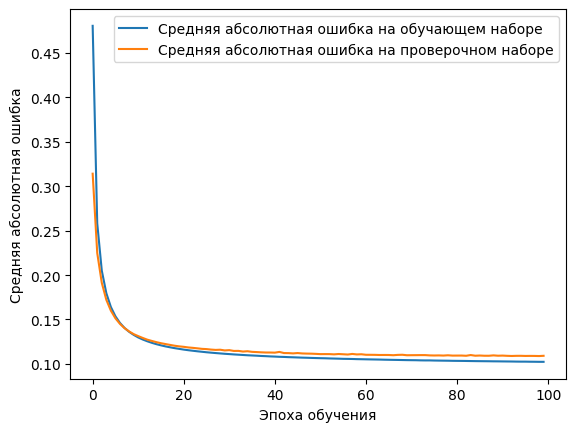

In [ ]:
#построим графики ошибки от эпох обучения
plt.plot(historyS.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(historyS.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

7085/7085 [==============================] - 11s 2ms/step
Средняя ошибка для обучающего набора: 
995.6243831840126
Средняя ошибка для тестового: 
1041.6329079816458


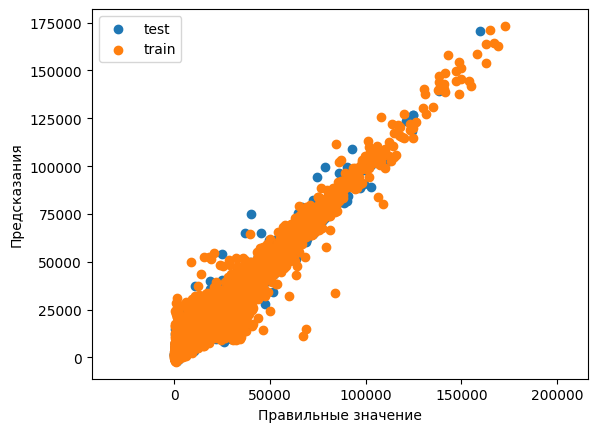

Для обучающего набора:
Реальное значение:
 258530    19000.0
14229     13100.0
158367    10500.0
11039      5750.0
142257    18800.0
Name: sellingprice, dtype: float64 
Предсказанное значение:
 [19869.287 13718.192 10545.157 12923.345 19695.512]
Для тестовых:
Реальное значение
 245631    10200.0
84047     13900.0
148609    20300.0
18574     15400.0
137346    12900.0
Name: sellingprice, dtype: float64 
Предсказанное значение
 [10767.873  9596.717 19530.602 16111.357 11323.871]


In [ ]:
#делаем предсказание, приводим его к начальному виду и находим среднее значение ошибки
pred = modelS.predict(X_test)
predUnscaled = yScaler.inverse_transform(pred).flatten()

pred_train = modelS.predict(X_train)
predUnscaled_train = yScaler.inverse_transform(pred_train).flatten()

print_res(predUnscaled, y_test, predUnscaled_train, y_train)

При увелечении количества эпох ошибка для теста увеличивается

# AutoML

In [ ]:
!pip install autokeras
'''!!!тут надо будет согласится с перезапуском, импортировать autokeras, а затем запусть все клетки, кроме секции (Создаем и обучаем нейросеть,
нейросеть на нормализованных данных)'''

'!!!тут надо будет согласится с перезапуском, импортировать autokeras, а затем запусть все клетки, кроме секции (Создаем и обучаем нейросеть,\nнейросеть на нормализованных данных)'

In [ ]:
#будем использовать AutoKeras
import autokeras as ak

Обучим на нормализованных данных

In [ ]:
#тут создадим модель AutoKeras
modelAS = ak.AutoModel(
    inputs=[ak.Input()],
    outputs=[ak.RegressionHead()],
    max_trials=5
)

history_AS = modelAS.fit(
    [X_train],
    [yTrainScaled],
    epochs=150
)

Trial 5 Complete [00h 19m 32s]
val_loss: 0.03679628297686577

Best val_loss So Far: 0.03679628297686577
Total elapsed time: 00h 41m 28s
Epoch 1/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 1.5683 - mean_squared_error: 1.5683
Epoch 2/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.6865 - mean_squared_error: 0.6865
Epoch 3/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 0.4526 - mean_squared_error: 0.4526
Epoch 4/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.3419 - mean_squared_error: 0.3419
Epoch 5/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2850 - mean_squared_error: 0.2850
Epoch 6/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 0.2524 - mean_squared_error: 0.2524
Epoch 7/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2208 - mean_squared_error: 0.2208
Epoch 8/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 0.2059 - mean_squared_error: 0.2059
Epoch 9/150
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 

In [ ]:
#теперь посмотрим нашу модель на тестовых данных и ошибки которые она дает
test_loss = modelAS.evaluate(np.array(X_test), np.array(yTestScaled))
test_loss

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1772/1772 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0342 - mean_squared_error: 0.0342


[0.0348929725587368, 0.0348929725587368]

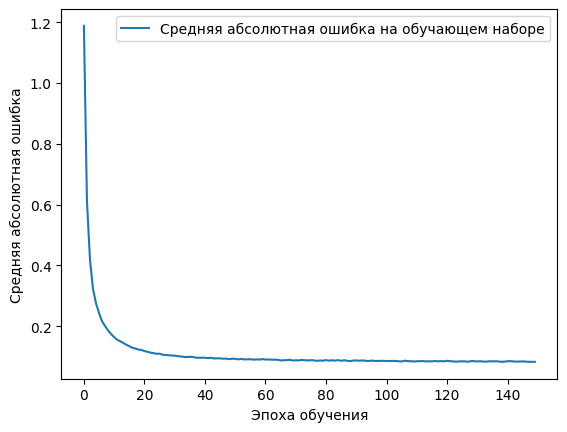

In [ ]:
#построим графики ошибки от эпох обучения
plt.plot(history_AS.history['mean_squared_error'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

1772/1772 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


7085/7085 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
Средняя ошибка для обучающего набора: 
1257.4640617327027
Средняя ошибка для тестового: 
1267.7258796157505


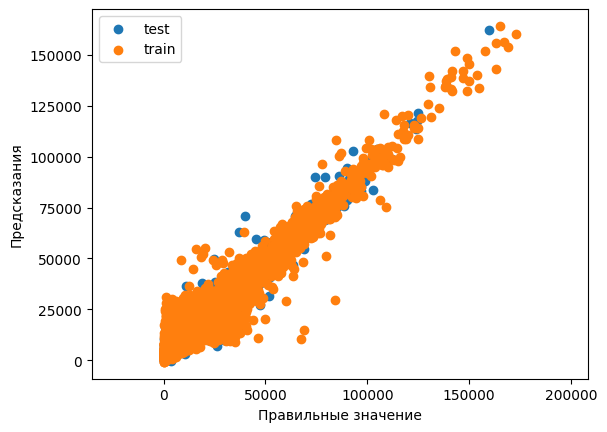

Для обучающего набора:
Реальное значение:
 258530    19000.0
14229     13100.0
158367    10500.0
11039      5750.0
142257    18800.0
Name: sellingprice, dtype: float64 
Предсказанное значение:
 [19036.193 13869.311 10423.389 12240.072 18821.832]
Для тестовых:
Реальное значение
 245631    10200.0
84047     13900.0
148609    20300.0
18574     15400.0
137346    12900.0
Name: sellingprice, dtype: float64 
Предсказанное значение
 [10607.898  9699.511 19867.607 15923.122 11330.891]


In [ ]:
#делаем предсказание, приводим его к начальному виду и находим среднее значение ошибки
pred = modelAS.predict(X_test)
predUnscaled = yScaler.inverse_transform(pred).flatten()

pred_train = modelAS.predict(X_train)
predUnscaled_train = yScaler.inverse_transform(pred_train).flatten()

print_res(predUnscaled, y_test, predUnscaled_train, y_train)

Теперь сделаем модель на ненормированных данных y_train и y_test.

In [ ]:
#тут создадим модель AutoKeras
modelA = ak.AutoModel(
    inputs=[ak.Input()],
    outputs=[ak.RegressionHead()],
    max_trials=3
)

history_A = modelA.fit(
    [X_train],
    [np.array(y_train)]
)

Trial 3 Complete [00h 00m 50s]
val_loss: 2777095.25

Best val_loss So Far: 2313908.75
Total elapsed time: 01h 07m 16s
Epoch 1/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 384us/step - loss: 79319880.0000 - mean_squared_error: 79319880.0000
Epoch 2/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 376us/step - loss: 3438023.0000 - mean_squared_error: 3438023.0000
Epoch 3/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 383us/step - loss: 3018251.2500 - mean_squared_error: 3018251.2500
Epoch 4/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 376us/step - loss: 2842413.5000 - mean_squared_error: 2842413.5000
Epoch 5/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 374us/step - loss: 2778590.2500 - mean_squared_error: 2778590.2500
Epoch 6/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 367us/step - loss: 2737514.5000 - mean_squared_error: 2737514.5000
Epoch 7/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 370us/step - loss: 2683387.2500 - mean_squared_error: 2683387.2500
Epoch 8/342
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 3s 368us/step - loss: 2642546.7500 - mean_squa

In [ ]:
#теперь посмотрим нашу модель на тестовых данных и ошибки которые она дает
test_loss = modelA.evaluate(np.array(X_test), np.array(y_test))
test_loss

 194/1772 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step - loss: 2144696.7500 - mean_squared_error: 2144696.7500  

/opt/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1772/1772 ━━━━━━━━━━━━━━━━━━━━ 1s 250us/step - loss: 2119707.2500 - mean_squared_error: 2119707.2500


[2158839.25, 2158839.25]

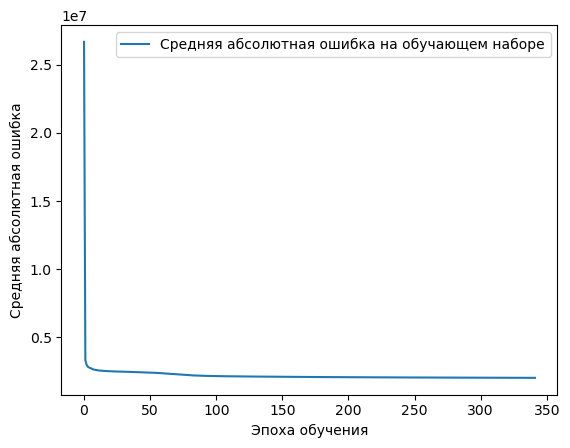

In [ ]:
#построим графики ошибки от эпох обучения
plt.plot(history_A.history['mean_squared_error'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
#делаем предсказание
pred = modelA.predict(X_test)

pred_train = modelA.predict(X_train)

1772/1772 ━━━━━━━━━━━━━━━━━━━━ 0s 262us/step
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 0s 259us/step
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step
7085/7085 ━━━━━━━━━━━━━━━━━━━━ 2s 254us/step


Средняя ошибка для обучающего набора: 
923.13373899565
Средняя ошибка для тестового: 
951.6978463716204


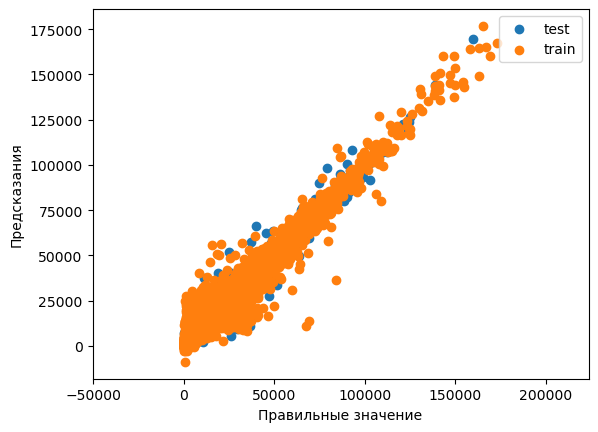

Для обучающего набора:
Реальное значение:
 [19000. 13100. 10500.  5750. 18800.] 
Предсказанное значение:
 [19980.111 13757.781 10626.924  9889.385 19191.916]
Для тестовых:
Реальное значение
 [10200. 13900. 20300. 15400. 12900.] 
Предсказанное значение
 [11669.423  9433.026 20259.572 16174.885 11604.96 ]


In [ ]:
print_res(pred.reshape(1, -1).squeeze(), np.array(y_test), pred_train.reshape(1, -1).squeeze(), np.array(y_train))

Получили очень хорошие результаты